# 통계 노드 Main Quest : 고객 행동 예측 및 고객 데이터 분석

### Orange Telecom 고객 이탈 데이터셋

## PART 1 & 2 : 문제 정의 및 이해 & 데이터 전처리


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, roc_auc_score
)
from sklearn.model_selection import cross_val_score, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance, partial_dependence

import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Mac 사용자는 'AppleGothic', Windows 사용자는 'Malgun Gothic' 등)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지


## 1-1 데이터와 친해지기 

1. churn-bigml - 80.csv 데이터 구조 파악 -> 20개 컬럼, 2666개 데이터

2. 결측치 확인 -> 결측치 없음!

In [2]:
train = pd.read_csv('churn-bigml-80.csv')

print(train.info()) 
print(train.isnull().any()) 
display(train.head())
print(train.describe())
print(train['Area code'].value_counts())
print(train['State'].value_counts())
print(train['Churn'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


       Account length    Area code  Number vmail messages  Total day minutes  \
count     2666.000000  2666.000000            2666.000000         2666.00000   
mean       100.620405   437.438860               8.021755          179.48162   
std         39.563974    42.521018              13.612277           54.21035   
min          1.000000   408.000000               0.000000            0.00000   
25%         73.000000   408.000000               0.000000          143.40000   
50%        100.000000   415.000000               0.000000          179.95000   
75%        127.000000   510.000000              19.000000          215.90000   
max        243.000000   510.000000              50.000000          350.80000   

       Total day calls  Total day charge  Total eve minutes  Total eve calls  \
count      2666.000000       2666.000000        2666.000000      2666.000000   
mean        100.310203         30.512404         200.386159       100.023631   
std          19.988162          9.21573

결과 : info()로 데이터를 보면 변수는 약20개, 행이 2666개의 non-null 데이터가 있음

isnull().any()로 결측치 확인, 결측치 없음 

## 비즈니스 목적별 할 수 있는 생각들

----- 이탈고객을 잡는게 목적! -----

### 1안 Churn - 고객 이탈 여부 vs 이탈에 영향을 주는 파생변수의 연결

### 2안 Churn - 요금을 많이 지불하는 사람들을 잡아야 하지 않을까? (Vip)

----- 마케팅 전략 제시가 목적! -----

### 3안 region vs (변수)로 나눠서 뭔가 지역별로 차이가 있지 않을까? 

결론부터 말하면 

1안의 경우 가장 정석적인 전체 고객의 이탈률 분석

2안의 경우 vip를 판단하는 파생변수를 만들어서(상위20프로 요금납부자) 이탈률 분석

3안의 경우 저의 개인적인 살짝 욕심이었지만 (포기)

## 1안 Churn - 고객 이탈 여부 vs 이탈에 영향을 주는 파생변수의 연결

In [3]:
#변수 생성 그냥 이것 저것 만들어 보았습니다

#위도가 비슷한 지역별 범주형 변환(욕심)
state_to_region = {
    # 동부 (East / Northeast)
    'NY': 'East', 'NJ': 'East', 'PA': 'East', 'CT': 'East', 'MA': 'East', 
    'ME': 'East', 'NH': 'East', 'RI': 'East', 'VT': 'East', 'DE': 'East', 
    'MD': 'East', 'DC': 'East', 'VA': 'East', 'WV': 'East',

    # 중부 및 남부 (Central / Midwest / South)
    'IL': 'Central', 'IN': 'Central', 'MI': 'Central', 'OH': 'Central', 'WI': 'Central',
    'IA': 'Central', 'KS': 'Central', 'MN': 'Central', 'MO': 'Central', 'NE': 'Central',
    'ND': 'Central', 'SD': 'Central', 'AL': 'Central', 'AR': 'Central', 'FL': 'Central',
    'GA': 'Central', 'KY': 'Central', 'LA': 'Central', 'MS': 'Central', 'NC': 'Central',
    'SC': 'Central', 'TN': 'Central', 'TX': 'Central', 'OK': 'Central',

    # 서부 (West / Mountain / Pacific)
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West', 
    'NM': 'West', 'UT': 'West', 'WY': 'West', 'AK': 'West', 'CA': 'West', 
    'HI': 'West', 'OR': 'West', 'WA': 'West'
}
train['Region'] = train['State'].str.strip().map(state_to_region)
print(train['Region'].value_counts())
#---------------------------------------------------------------------------------


#파생변수 생성 (콜당 요금) 나누기 오류 제거 +1
train['Charge per calls day'] = train['Total day charge'] / (train['Total day calls']+1)
train['Charge per calls eve'] = train['Total eve charge'] / (train['Total eve calls']+1) 
train['Charge per calls night'] = train['Total night charge'] / (train['Total night calls']+1) 
train['Charge per calls intl'] = train['Total intl charge'] / (train['Total intl calls']+1)

#총 전화 횟수
train['Total calls'] = train['Total day calls'] + train['Total eve calls'] +train['Total night calls'] + train['Total intl calls']
print(train['Total calls'])
#총 요금
train['Total charge'] = train['Total day charge'] + train['Total eve charge'] +train['Total night charge'] + train['Total intl charge']
print(train['Total charge'])
#그 비율
train['Charge per calls total'] = train['Total charge'] / (train['Total calls'])

print(train['Charge per calls day'].head())
print(train['Charge per calls eve'].head())
print(train['Charge per calls night'].head())
print(train['Charge per calls intl'].head())

#요금제 유무에 관한 더미 변수 yes=1 , no=0
train['International plan_dummy'] = train['International plan'].map({'Yes': 1, 'No': 0})
train['Voice mail plan_dummy'] = train['Voice mail plan'].map({'Yes': 1, 'No': 0}) 



Region
Central    1228
East        773
West        665
Name: count, dtype: int64
0       303
1       332
2       333
3       255
4       359
       ... 
2661    299
2662    292
2663    239
2664    264
2665    276
Name: Total calls, Length: 2666, dtype: int64
0       75.56
1       59.24
2       62.29
3       66.80
4       52.09
        ...  
2661    52.17
2662    60.10
2663    63.53
2664    67.74
2665    77.01
Name: Total charge, Length: 2666, dtype: float64
0    0.406036
1    0.221532
2    0.359826
3    0.706944
4    0.248596
Name: Charge per calls day, dtype: float64
0    0.167800
1    0.159808
2    0.092793
3    0.059101
4    0.102520
Name: Charge per calls eve, dtype: float64
0    0.119674
1    0.110096
2    0.069714
3    0.098444
4    0.068934
Name: Charge per calls night, dtype: float64
0    0.675000
1    0.925000
2    0.548333
3    0.222500
4    0.682500
Name: Charge per calls intl, dtype: float64


파생변수인 Charge per calls () 의 경우, (Charge / call+1)의 식으로 구성

(call의 수가 시간 별로 0인 경우가 있기 때문에 오류 발생.)

## PART3 : DEEP EDA

#### 고객센터 전화 수에 따른 이탈률

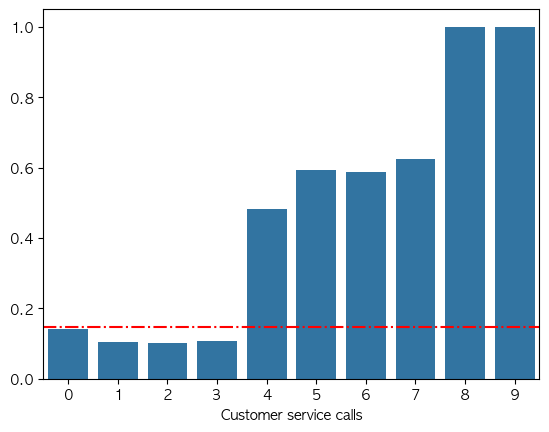

In [4]:
service_churn = train.groupby('Customer service calls')['Churn'].mean()

# 시각화
sns.barplot(x=service_churn.index, y=service_churn.values)
plt.axhline(train['Churn'].mean(), color='red', linestyle='-.') # 전체 평균 이탈률 선
plt.show()


결과 : 고객센터 전화가 4회 이상인 고객은 이탈율이 높다.

#### 두 요금제 유무와 이탈률의 카이제곱 독립성 검정

In [5]:

#범주 vs 범주 카이제곱 검정
crosstab1 = pd.crosstab(train['Voice mail plan'], train['Churn'])
display(crosstab1)

chi2, p, dof, expected = chi2_contingency(crosstab1)
print(f"카이제곱 통계량: {chi2:.4f}")
print(f"P-value: {p:.4f}")

crosstab2 = pd.crosstab(train['International plan'], train['Churn'])
display(crosstab2)


chi2, p, dof, expected = chi2_contingency(crosstab2)
print(f"카이제곱 통계량: {chi2:.4f}")
print(f"P-value: {p:.4f}")


Churn,False,True
Voice mail plan,,
No,1610,323
Yes,668,65


카이제곱 통계량: 25.6563
P-value: 0.0000


Churn,False,True
International plan,,
No,2126,270
Yes,152,118


카이제곱 통계량: 202.6821
P-value: 0.0000


p-value가 0으로 두 요금제의 유무는 모두 이탈율과 연관이 있다!

국제전화 가입 고객은 미가입 고객보다 이탈률이 높음 (43.7% vs 11.3%)

voice mail 미가입 고객은 가입보객보다 높음 (16.7% vs 8.9%)

국제전화 서비스 가입을 한 고객의 이탈률이 높다? > 국제전화 서비스 품질에 문제가 있을 것 같음 

### 상관관계 분석 (다중공선성)

total (시간) charge - total (시간) minutes 는 상관계수가 1 , 즉 완전히 동일정보를 담고 있다는 뜻

그럼 둘 중 한 변수만 제거 후 분석하면 나머지 변수들은 선형관계가 존재하지 않음

(추가적으로 기존의 변수를 이용해서 만든 파생변수들도 포함)

<Axes: >

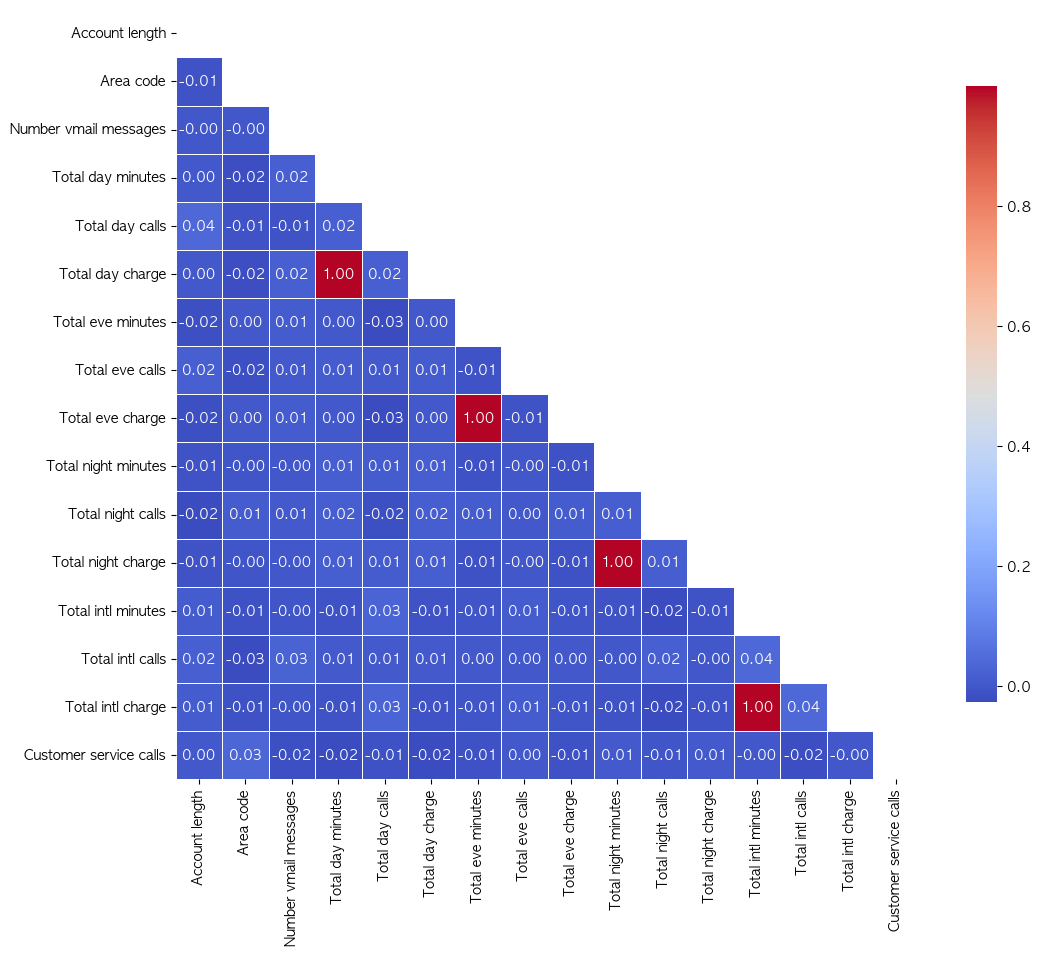

In [6]:
train1 = pd.read_csv("churn-bigml-80.csv")

train_numeric = [col for col in train1.columns if train1[col].dtype in ['int64', 'float64']]

corr_matrix = train1[train_numeric].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
    linewidths=0.5,cbar_kws={"shrink": 0.8})

## 2안 Churn - 요금을 많이 지불하는 사람들을 잡아야 하지 않을까? (Vip) 

### ⭐ VIP 정의
VIP는 **“Total charge(총 요금)”** 하나로 정의  
-> minutes와 charge는 상관이 1에 가까워 중복 정보로 판단되어, VIP는 총 요금(Total charge) 상위 20%로 정의했다.

In [7]:
# Churn을 0/1로 변환 (True면 1, False면 0)
train["Churn_flag"] = (train["Churn"].astype(str) == "True").astype(int)

# VIP 컷: Total_charge 상위 20%
vip_cut = train["Total charge"].quantile(0.80)

# VIP 여부 (1=VIP, 0=Non-VIP)
train["VIP"] = (train["Total charge"] >= vip_cut).astype(int)

print("📌 VIP cut (80th percentile):", vip_cut)
print("\n📌 VIP 비율 확인")
print(train["VIP"].value_counts())
print(train["VIP"].value_counts(normalize=True))

📌 VIP cut (80th percentile): 68.26

📌 VIP 비율 확인
VIP
0    2132
1     534
Name: count, dtype: int64
VIP
0    0.7997
1    0.2003
Name: proportion, dtype: float64


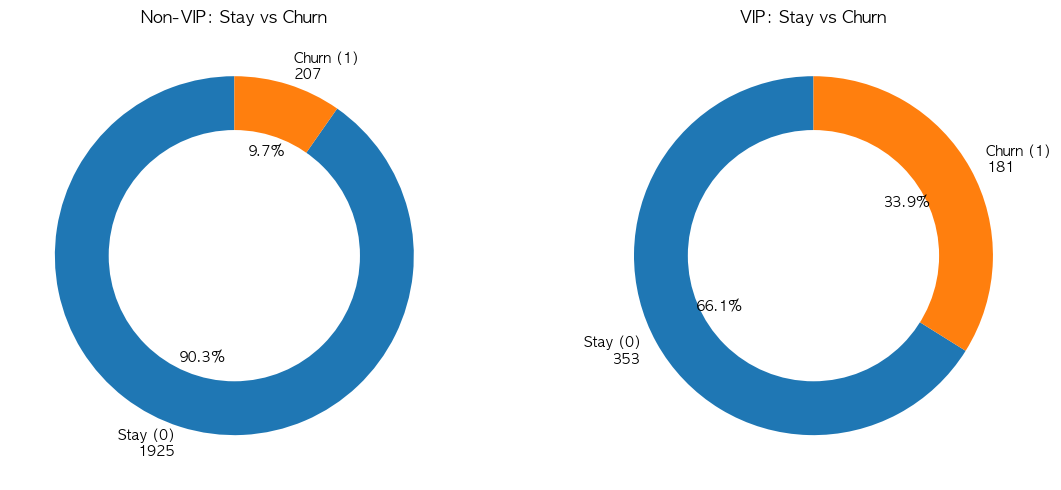

In [8]:
vip_summary = train.groupby("VIP")["Churn_flag"].agg(["count", "mean"]).reset_index()
vip_summary["churn_rate(%)"] = vip_summary["mean"] * 100

def donut_chart(df, title):
    # Stay(0), Churn(1) 개수 세기
    counts = df["Churn_flag"].value_counts().sort_index()

    # 혹시 한쪽 값이 없을 수도 있으니 안전하게 맞춰주기
    stay = counts.get(0, 0)
    churn = counts.get(1, 0)

    sizes = [stay, churn]
    labels = [f"Stay (0)\n{stay}", f"Churn (1)\n{churn}"]

    # 도넛 그리기
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=labels,
        autopct="%.1f%%",
        startangle=90
    )

    # 가운데 구멍 만들기
    centre_circle = plt.Circle((0, 0), 0.70, fc="white")
    plt.gca().add_artist(centre_circle)

    plt.title(title)


# Non-VIP / VIP 데이터 분리
nonvip_df = train[train["VIP"] == 0]
vip_df    = train[train["VIP"] == 1]

# 그래프 2개 나란히
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
donut_chart(nonvip_df, "Non-VIP: Stay vs Churn")

plt.subplot(1, 2, 2)
donut_chart(vip_df, "VIP: Stay vs Churn")

plt.tight_layout()
plt.show()

VIP stable size: (493, 33)
VIP high complaint size: (41, 33)


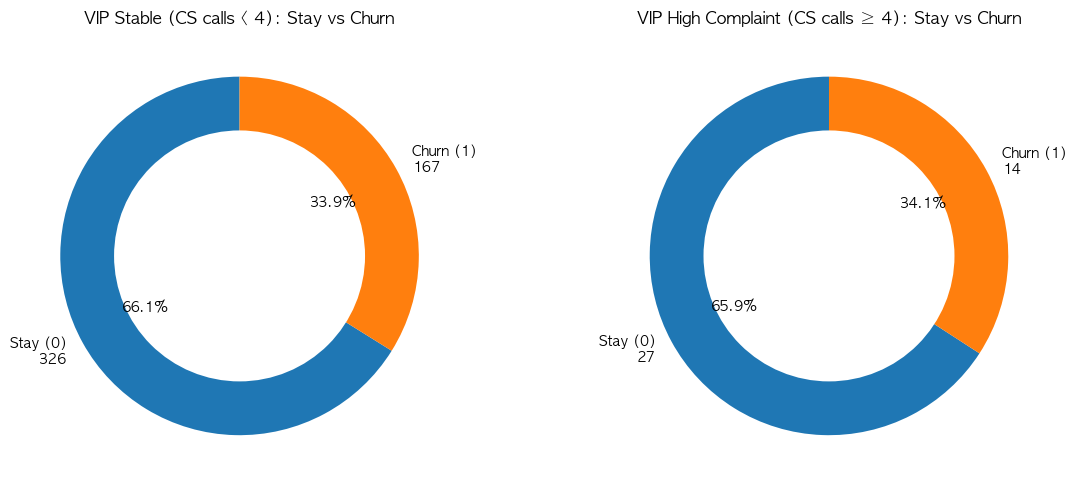

,Group,count,churn_rate(%)
0,VIP Stable (CS < 4),493,33.874239
1,VIP High Complaint (CS ≥ 4),41,34.146341


In [9]:
# 불만 높은 고객 정의
train["High_complaint"] = (train["Customer service calls"] >= 4).astype(int)

# VIP 고객만 따로 뽑기
vip_only = train[train["VIP"] == 1]

# VIP 안정 그룹 / VIP 불만 그룹
vip_stable = vip_only[vip_only["High_complaint"] == 0]
vip_risk   = vip_only[vip_only["High_complaint"] == 1]

print("VIP stable size:", vip_stable.shape)
print("VIP high complaint size:", vip_risk.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
donut_chart(vip_stable, "VIP Stable (CS calls < 4): Stay vs Churn")

plt.subplot(1, 2, 2)
donut_chart(vip_risk, "VIP High Complaint (CS calls ≥ 4): Stay vs Churn")

plt.tight_layout()
plt.show()

vip_complaint_summary = vip_only.groupby("High_complaint")["Churn_flag"].agg(["count", "mean"]).reset_index()
vip_complaint_summary["churn_rate(%)"] = vip_complaint_summary["mean"] * 100
vip_complaint_summary["Group"] = vip_complaint_summary["High_complaint"].map({
    0: "VIP Stable (CS < 4)",
    1: "VIP High Complaint (CS ≥ 4)"
})

display(vip_complaint_summary[["Group", "count", "churn_rate(%)"]])

전체 고객에서는 CS calls가 중요한 변수로 알려져 있지만, VIP 그룹에서는 단순 CS calls 기준만으로는 위험군 분리가 잘 되지 않았다. 따라서 VIP의 이탈은 ‘불만’ 외에 다른 요인(요금제/국제통화/사용패턴)의 영향이 더 클 가능성이 있다. 그래서 한번 더 확인해보자

,Customer service calls,Churn_flag,churn_rate(%)
0,0,0.383929,38.392857
1,1,0.330000,33.000000
2,2,0.330189,33.018868
3,3,0.306667,30.666667
4,4,0.321429,32.142857
5,5,0.400000,40.000000
6,6,0.000000,0.000000
7,7,0.000000,0.000000
8,9,1.000000,100.000000


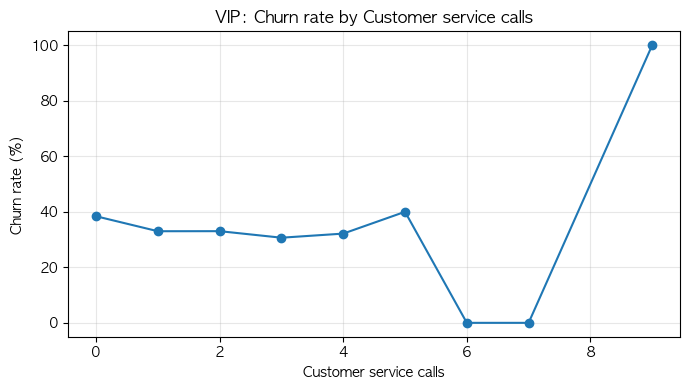

In [10]:
vip_only = train[train["VIP"] == 1].copy()

cs_rate = vip_only.groupby("Customer service calls")["Churn_flag"].mean().reset_index()
cs_rate["churn_rate(%)"] = cs_rate["Churn_flag"] * 100

display(cs_rate)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(cs_rate["Customer service calls"], cs_rate["churn_rate(%)"], marker="o")
plt.xlabel("Customer service calls")
plt.ylabel("Churn rate (%)")
plt.title("VIP: Churn rate by Customer service calls")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

CS calls 6회 이상은 이탈률이 높아 보이긴 함  
근데 표본 수가 너무 적어서 “규칙”으로 쓰기엔 위험  
→ 그래서 “VIP 위험군 기준”으로는 부적절

In [11]:
# VIP 위험 요인 후보 1: International plan (국제요금제)
vip_only = train[train["VIP"] == 1].copy()

plan_rate = vip_only.groupby("International plan")["Churn_flag"].mean().reset_index()
plan_rate["churn_rate(%)"] = plan_rate["Churn_flag"] * 100
display(plan_rate)


,International plan,Churn_flag,churn_rate(%)
0,No,0.300000,30.000000
1,Yes,0.581081,58.108108


1. VIP 고객 중에서도 International plan 가입자는 churn rate가 **58.1%**로, 미가입자(30.0%) 대비 약 1.9배 높았다.

2. VIP 고객 중에서 **국제통화를 많이 쓰는 상위 20%** 를 1로 표시하고 나머지 80%는 0으로 했을 때 이탈율을 확인해보면 VIP 중 국제통화 사용량 상위 20% 고객의 이탈률이 더 높아, 국제통화 혜택 최적화가 필요하다.

국제 통화를 많이 쓰는 고객은 보통 국제요금제/요금에 민감할 수 있고 다른 통신사/앱(왓츠앱, 스카이프 등)으로 이동할 가능성도 있고 요금 불만이 생기기 쉬움

3. 낮 시간대에 통화를 몇 번 했는지 대비 요금이 얼마나 나왔는지



,International plan,Churn_flag,churn_rate(%)
0,No,0.300000,30.000000
1,Yes,0.581081,58.108108


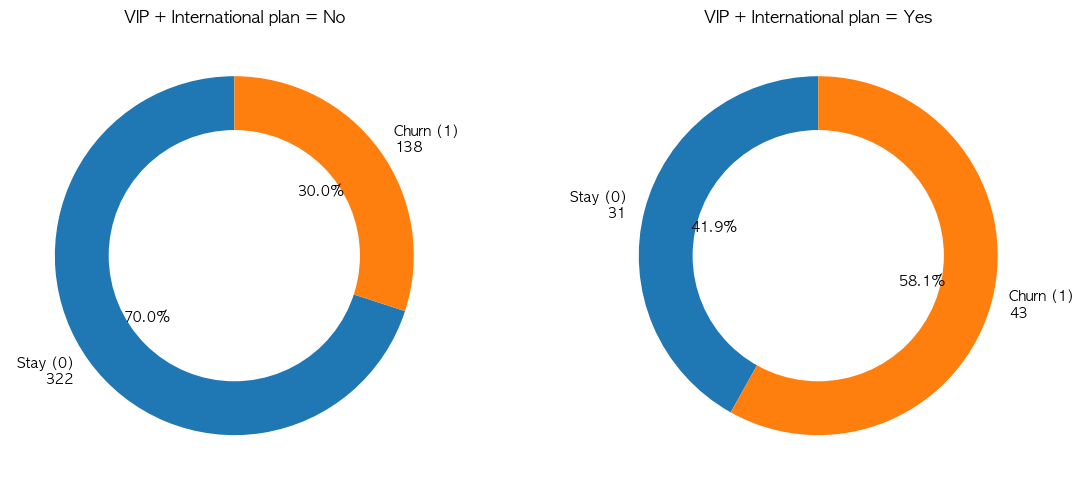

In [12]:
# VIP 위험 요인 후보 1: International plan (국제요금제)
vip_only = train[train["VIP"] == 1].copy()

plan_rate = vip_only.groupby("International plan")["Churn_flag"].mean().reset_index()
plan_rate["churn_rate(%)"] = plan_rate["Churn_flag"] * 100
display(plan_rate)

vip_intl_no  = vip_only[vip_only["International plan"] == "No"]
vip_intl_yes = vip_only[vip_only["International plan"] == "Yes"]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
donut_chart(vip_intl_no, "VIP + International plan = No")

plt.subplot(1, 2, 2)
donut_chart(vip_intl_yes, "VIP + International plan = Yes")

plt.tight_layout()
plt.show()

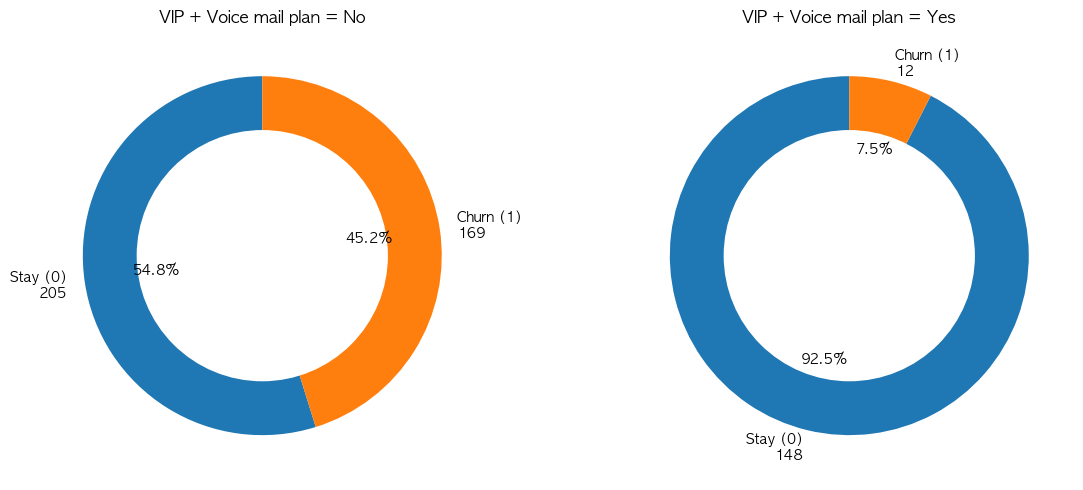

In [13]:
# VIP 위험 요인 후보 2: Voice mail plan (음성사서함 요금제)
vip_vm_no  = vip_only[vip_only["Voice mail plan"] == "No"]
vip_vm_yes = vip_only[vip_only["Voice mail plan"] == "Yes"]

vip_only.groupby("Voice mail plan")["Churn_flag"].agg(["count","mean"]).assign(
    churn_rate_percent=lambda x: x["mean"]*100
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
donut_chart(vip_vm_no, "VIP + Voice mail plan = No")

plt.subplot(1, 2, 2)
donut_chart(vip_vm_yes, "VIP + Voice mail plan = Yes")

plt.tight_layout()
plt.show()


In [14]:
# VIP 위험 요인 후보 3: Total intl minutes가 높은 상위 20% 고객
vip_only["Intl_high"] = (vip_only["Total intl minutes"] >= vip_only["Total intl minutes"].quantile(0.80)).astype(int)

intl_summary = vip_only.groupby("Intl_high")["Churn_flag"].agg(["count","mean"]).reset_index()
intl_summary["churn_rate(%)"] = intl_summary["mean"]*100
display(intl_summary)

,Intl_high,count,mean,churn_rate(%)
0,0,422,0.310427,31.042654
1,1,112,0.446429,44.642857


In [15]:
# VIP 위험 요인 후보 4: 콜당 요금이 높은 상위 20% 고객
vip_only = train[train["VIP"] == 1].copy()

# 시간대별 콜당 요금(0으로 나누기 방지 +1)
vip_only["charge_per_call_day"]   = vip_only["Total day charge"]   / (vip_only["Total day calls"] + 1)
vip_only["charge_per_call_eve"]   = vip_only["Total eve charge"]   / (vip_only["Total eve calls"] + 1)
vip_only["charge_per_call_night"] = vip_only["Total night charge"] / (vip_only["Total night calls"] + 1)
vip_only["charge_per_call_intl"]  = vip_only["Total intl charge"]  / (vip_only["Total intl calls"] + 1)

# 상위 20%를 high cost로 만들기
for col in ["charge_per_call_day", "charge_per_call_eve", "charge_per_call_night", "charge_per_call_intl"]:
    flag_col = col + "_high"
    vip_only[flag_col] = (vip_only[col] >= vip_only[col].quantile(0.80)).astype(int)

    summary = vip_only.groupby(flag_col)["Churn_flag"].agg(["count","mean"]).reset_index()
    summary["churn_rate(%)"] = summary["mean"] * 100

    print(f"\n📌 {col} (Top 20% high vs others)")
    display(summary)


📌 charge_per_call_day (Top 20% high vs others)


,charge_per_call_day_high,count,mean,churn_rate(%)
0,0,427,0.320843,32.084309
1,1,107,0.411215,41.121495



📌 charge_per_call_eve (Top 20% high vs others)


,charge_per_call_eve_high,count,mean,churn_rate(%)
0,0,426,0.338028,33.802817
1,1,108,0.342593,34.259259



📌 charge_per_call_night (Top 20% high vs others)


,charge_per_call_night_high,count,mean,churn_rate(%)
0,0,427,0.327869,32.786885
1,1,107,0.383178,38.317757



📌 charge_per_call_intl (Top 20% high vs others)


,charge_per_call_intl_high,count,mean,churn_rate(%)
0,0,427,0.325527,32.552693
1,1,107,0.392523,39.252336


#### DEEP EDA 의 시사점

1안과 2안의 공통적인 가설 : 요금제 2개의 가입 유무, 콜당 요금, 고객센터 전화 횟수가 이탈율에 영향을 줄것이다! (vip든 전체고객이든)

다만, 2안으로 모델을 학습하면 일반 고객한테 적용하기가 힘든 "vip의 이탈을 막는 모델"이 나온다 생각했습니다.

즉, 모델의 일반화 성능을 위해서 전체고객(1안)으로 이탈자 예측 모델을 만드는게 더 효과적이라 판단!

## PART4 모델 학습

### 1-1. 로지스틱회귀 모델 적합

후진제거법을 쓸 예정이기 때문에 우선 포화모형을 fitting

In [16]:
#로지스틱 회귀 일단 해봅시다
y1 = train['Churn'].astype(int)
X1 = train[['International plan_dummy','Voice mail plan_dummy','Customer service calls','Charge per calls day','Charge per calls eve','Charge per calls night','Charge per calls intl']]
X1_const = sm.add_constant(X1)

model1 = sm.Logit(y1,X1_const).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.339610
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2658
Method:                           MLE   Df Model:                            7
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                  0.1814
Time:                        21:54:01   Log-Likelihood:                -905.40
converged:                       True   LL-Null:                       -1106.1
Covariance Type:            nonrobust   LLR p-value:                 1.207e-82
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -5.2314      0.352    -14.860      0.000      -5.921

첫 로지스틱 회귀 fitting 후 Charge per calls night 변수가 유의하지 않음

Charge per calls eve 변수도 한번 제거 해보았습니다 p-value 0.026? 나머지는 0에 가까웠는데 맘에 안들었습니다.

그 두 변수 제거 후 다시 fitting (후진제거법) -> 모든 회귀계수가 유의함!

In [17]:
#Feature selection 1

y2 = train['Churn'].astype(int)
X2 = train[['International plan_dummy','Voice mail plan_dummy','Customer service calls','Charge per calls day','Charge per calls intl']]
X2_const = sm.add_constant(X2)

model2 = sm.Logit(y2,X2_const).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.340832
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2660
Method:                           MLE   Df Model:                            5
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                  0.1785
Time:                        21:54:02   Log-Likelihood:                -908.66
converged:                       True   LL-Null:                       -1106.1
Covariance Type:            nonrobust   LLR p-value:                 3.788e-83
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -4.6617      0.250    -18.656      0.000      -5.151

혹시모를 로지스틱 회귀모형의 다중공선성 존재를 확인하기 위해 VIF 확인

In [18]:
# 상수항을 포함한 X 데이터의 VIF 계산
X2_const = sm.add_constant(X2)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2_const.values, i) for i in range(X2_const.shape[1])]
vif["features"] = X2_const.columns
print(vif)

   VIF Factor                  features
0   13.474987                     const
1    1.004420  International plan_dummy
2    1.000804     Voice mail plan_dummy
3    1.002127    Customer service calls
4    1.003014      Charge per calls day
5    1.001320     Charge per calls intl


상수항 제외 1에 가까운 값으로 매우 작음  -> 다중공선성은 의심 안 됨!

### 1-2. 5-Fold Cross Validation

In [19]:
#5-fold cross validation
model_lr = LogisticRegression(solver='liblinear')
cv_scores = cross_val_score(model_lr ,X2 ,y2, cv=5,scoring="roc_auc")

print(f"[5-Fold Cross Validation Results]")
print(f"Scores per fold: {np.round(cv_scores, 4)}")
print(f"Mean : {cv_scores.mean():.4f}")
print(f"Std Dev: {cv_scores.std():.4f}")



[5-Fold Cross Validation Results]
Scores per fold: [0.785  0.7293 0.7901 0.7904 0.8068]
Mean : 0.7803
Std Dev: 0.0266


### 2-1. LASSO Regression 5-fold CV

Feature selection을 통해 로지스틱 회귀를 두 차례 적합하였으나

변수선택의 객관성, 일반화 성능을 확보하기 위해 변수선택에 최적화된 LASSO regression 사용

In [63]:
model_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1)
# 1. 모델을 전체 학습 데이터에 적합
model_lasso.fit(X1, y1)

# 2. 계수(Coefficients) 확인
lasso_coef = pd.Series(model_lasso.coef_[0], index=X1.columns)

# 3. 0이 된 변수(제거된 변수)와 살아남은 변수 출력
zero_features = lasso_coef[lasso_coef == 0].index.tolist()
live_features = lasso_coef[lasso_coef != 0].index.tolist()

print(f"제거된 변수:{zero_features}") #제거된 변수

제거된 변수:['Charge per calls night']


In [21]:
model_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1)

lasso_cv_auc = cross_val_score(model_lasso, X2, y2, cv=5, scoring='roc_auc')

print(f"[LASSO 5-Fold Cross Validation (AUC)]")
print(f"AUC Scores per fold: {np.round(lasso_cv_auc, 4)}")
print(f"Mean AUC: {lasso_cv_auc.mean():.4f}")
print(f"Std Dev: {lasso_cv_auc.std():.4f}")

# 3. 기존 일반 로지스틱 결과와 비교 로직
if lasso_cv_auc.mean() > cv_scores.mean() : 
    print("\n LASSO 모델이 일반 모델보다 예측 성능이 더 좋습니다!")
else:
    print("\n 일반 로지스틱 모델과 성능이 비슷")

[LASSO 5-Fold Cross Validation (AUC)]
AUC Scores per fold: [0.7889 0.7335 0.791  0.7953 0.8069]
Mean AUC: 0.7831
Std Dev: 0.0256

 LASSO 모델이 일반 모델보다 예측 성능이 더 좋습니다!


## Random Forest 

앞에 두개는 사실 선형모델로 했는데 비선형모델인 랜덤포레스트도 실행

표본이 그다지 많지 않기 때문에 충분히 GridSearchCV 하이퍼파라미터 튜닝으로

모든 파라미터 조합을 전수조사하고, 예측력을 극대화 할 수 있는 최적의 조합을 도출.

In [22]:
# 1. 테스트할 파라미터 그리드 설정
params= {
    'n_estimators': [100, 200],      # 나무 개수
    'max_depth': [3, 5, 7, 10],      # 나무 깊이 (과적합 방지 핵심)
    'min_samples_leaf': [5, 10, 20], # 한 잎사귀에 필요한 최소 샘플 수
    'max_features': ['sqrt', 'log2'] # 각 나무가 학습할 때 사용할 변수 개수
}

#GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced',random_state=42),
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X2,y2)

#최적의 결과 확인
print(f"최적의 파라미터: {grid_search.best_params_}")
print(f"최적 파라미터에서의 Mean AUC: {grid_search.best_score_:.4f}")

#최적의 모델 저장
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
최적의 파라미터: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 200}
최적 파라미터에서의 Mean AUC: 0.8462


class_weight = 'balanced'옵션으로 일부 정밀도를 희생하고 Recall(재현율)을 끌어 올렸음

그 결과, 확실히 AUC 가 약0.85로 나와서 비선형 모델이 더 예측성능이 좋음!

In [29]:
features = [
    'International plan_dummy','Voice mail plan_dummy',
    'Customer service calls','Charge per calls day','Charge per calls intl'
]

X_train = train[features]
y_train = train['Churn']

y_pred_train = best_rf_model.predict(X_train)
y_prob_train = best_rf_model.predict_proba(X_train)

print(classification_report(y_train, y_pred_train, digits=3))

y_prob = best_rf_model.predict_proba(X_train)[:, 1]
print(f"train set 모델 AUC: {roc_auc_score(y_train, y_prob):.4f}")


              precision    recall  f1-score   support

       False      0.959     0.822     0.885      2278
        True      0.431     0.791     0.558       388

    accuracy                          0.817      2666
   macro avg      0.695     0.807     0.721      2666
weighted avg      0.882     0.817     0.837      2666

train set 모델 AUC: 0.8848


Train set으로 평가 결과

AUC = 0.8848 & 1(TRUE) 의 재현률(0.791) 가 나왔음 

-> 이탈고객을 약 "79프로" 정도 예측 가능! 하지만,

문제점 : precision(정밀도) & f1-score 는 각각 0.431 & 0.558 으로 다소 낮음.

아무래도 train set 중 이탈자의 비율이 약 14~15% 정도이기 때문에, 데이터 불균형에 대한 결과로

정밀도를 희생했다고 볼 수 있음.

## PART5 모델 평가

### 5-1. test set 

이제 학습된 모델을 기반으로 test set의 성능을 평가해보겠습니다.

In [30]:
test = pd.read_csv('churn-bigml-20.csv')

def preprocess_churn_data(df):
    df['International plan_dummy'] = df['International plan'].map({'Yes': 1, 'No': 0})
    df['Voice mail plan_dummy'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})
    df['Charge per calls day'] = df['Total day charge'] / df['Total day calls']
    df['Charge per calls eve'] = df['Total eve charge'] / df['Total eve calls']
    df['Charge per calls night'] = df['Total night charge'] / df['Total night calls']
    df['Charge per calls intl'] = df['Total intl charge'] / df['Total intl calls']
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)
    if 'Churn' in df.columns:
        df['Churn'] = df['Churn'].astype(int)
    
    return df
test = preprocess_churn_data(test)

In [31]:
features = [
    'International plan_dummy','Voice mail plan_dummy',
    'Customer service calls','Charge per calls day','Charge per calls intl'
]

X_test = test[features]
y_test = test['Churn']

In [32]:
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=3))

y_prob = best_rf_model.predict_proba(X_test)[:, 1]
print(f"test set 모델 AUC: {roc_auc_score(y_test, y_prob):.4f}")


              precision    recall  f1-score   support

           0      0.951     0.816     0.879       572
           1      0.403     0.747     0.524        95

    accuracy                          0.807       667
   macro avg      0.677     0.782     0.701       667
weighted avg      0.873     0.807     0.828       667

test set 모델 AUC: 0.8165


Test set으로 최종성능 평가 결과

AUC = 0.8165 & 1(TRUE) 의 재현률(0.747) 가 나왔음 

-> 이탈고객을 약 "75프로" 정도 예측 가능! 하지만,

문제점 : precision(정밀도) & f1-score 는 각각 0.403 & 0.524 으로 다소 낮음.

아무래도 데이터 중 이탈자의 비율이 약 15프로정도이기 때문에, 데이터 불균형에 대한 결과로

정밀도를 희생함.


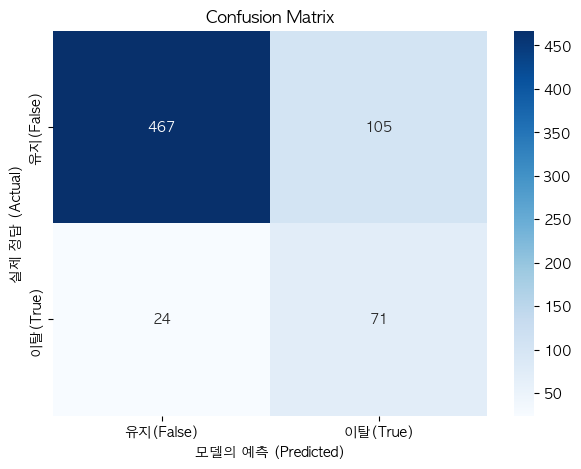

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       572
           1       0.40      0.75      0.52        95

    accuracy                           0.81       667
   macro avg       0.68      0.78      0.70       667
weighted avg       0.87      0.81      0.83       667



In [33]:
y_pred = best_rf_model.predict(X_test[features]) # 혹은 설정하신 최종 모델 변수명

# 2. 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 3. 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['유지(False)', '이탈(True)'], 
            yticklabels=['유지(False)', '이탈(True)'])

plt.xlabel('모델의 예측 (Predicted)')
plt.ylabel('실제 정답 (Actual)')
plt.title('Confusion Matrix')
plt.show()

#classification_report 확인
print(classification_report(y_test, y_pred))

sensitivity = 71 /(71+24) #이게 사실 RECALL

## PART 6 : 모델 해석

### 6-1. Feature Importance 분석

여기선 랜덤포레스트 와인데이터의 모델 해석 부분을 대부분 참고하였습니다

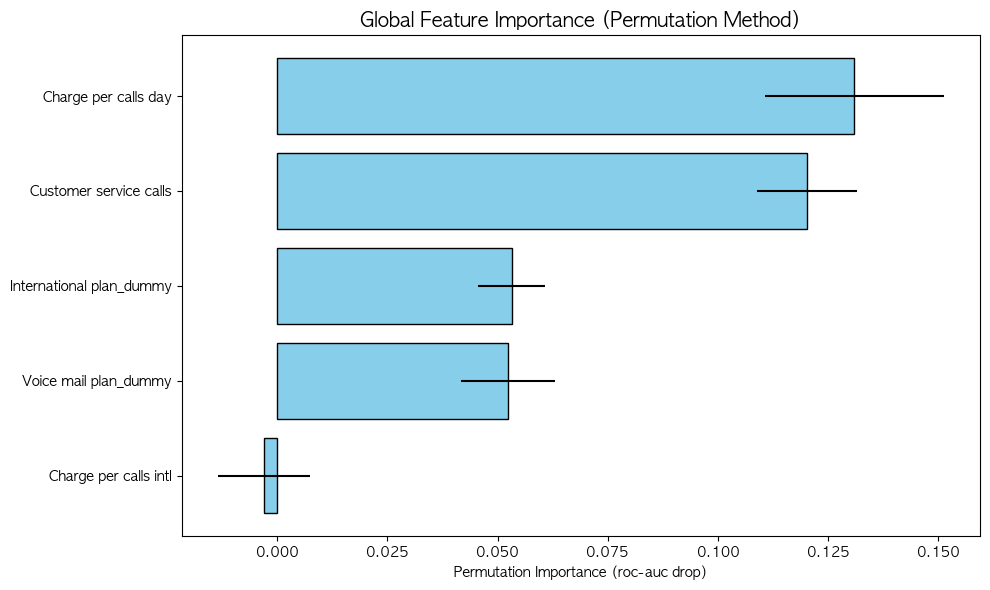

In [34]:
result = permutation_importance(
    best_rf_model,X_test,y_test,
    n_repeats=10,random_state=42,n_jobs=-1,
    scoring = 'roc_auc'
)

sorted_idx = result.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)), 
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx],
    color='skyblue',
    edgecolor='black'
)
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel('Permutation Importance (roc-auc drop)')
plt.title('Global Feature Importance (Permutation Method)', fontsize=14)
plt.tight_layout()
plt.show()

permutation importance 결과 분석

Charge per calls day & Customer service calls 가 다른 변수 대비 AUC감소 폭이

가장 크게 나타남, 이 두 변수가 가장 중요한 이탈 예측 변수로 확인.

### 6-2. Partial Dependence Plot & Individual Sample Simulation

가장 중요한 변수들인 Chargeper per calls day & Customer service calls

이 둘의 값을 변화 시키면서 다른 모든 변수는 유지하고, 이탈자의 예측확률이 어떻게 변하는지 추적

특정 고객 1명을 선택해서 그 고객의 Chargeper per calls day & Customer service calls 들을 변화시키고 다른 모든 변수들은 고정한 채 등급 확률이 어떻게 변하는지 시뮬레이션.

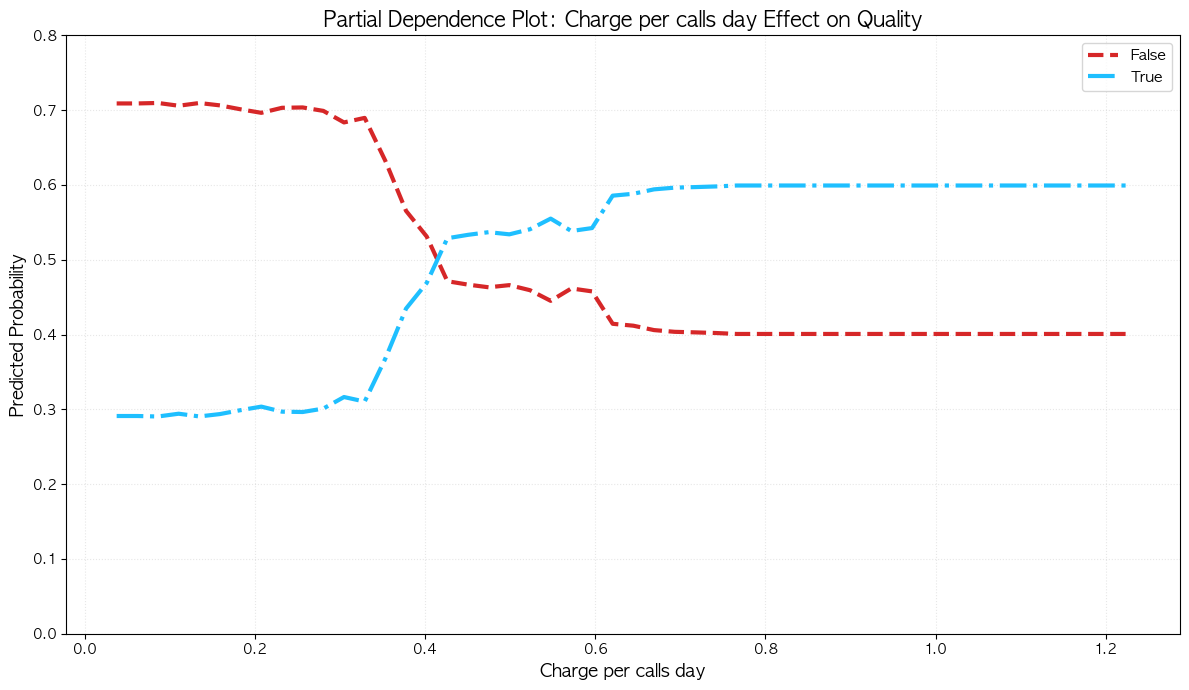

In [64]:
top_feature = X_test.columns[sorted_idx[0]]

grid_values = np.linspace(X_test[top_feature].min(), X_test[top_feature].max(), 50)
prob_trajectories = {0: [], 1: []}

for val in grid_values:
    X_temp = X_test.copy()
    X_temp[top_feature] = val

    # 평균 확률 계산
    probs = best_rf_model.predict_proba(X_temp).mean(axis=0)
    for cls in range(2):
        prob_trajectories[cls].append(probs[cls])

fig, ax = plt.subplots(figsize=(12, 7))

colors = ['#d62728',"#1ebfff"] 
labels = [False , True]
linestyles = ['--', '-.']

for cls in range(2):
    ax.plot(
        grid_values, 
        prob_trajectories[cls], 
        label=labels[cls], 
        color=colors[cls], 
        linewidth=3,
        linestyle=linestyles[cls]
    )

ax.set_xlabel(f'{top_feature}', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted Probability', fontsize=13, fontweight='bold')
ax.set_title(f'Partial Dependence Plot: {top_feature} Effect on Quality', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle=':')
ax.set_ylim(0, 0.8)
plt.tight_layout()
plt.show()



  International plan_dummy: 0.00
  Voice mail plan_dummy: 0.00
  Customer service calls: 1.00
  Charge per calls day: 0.32
  Charge per calls intl: 0.59


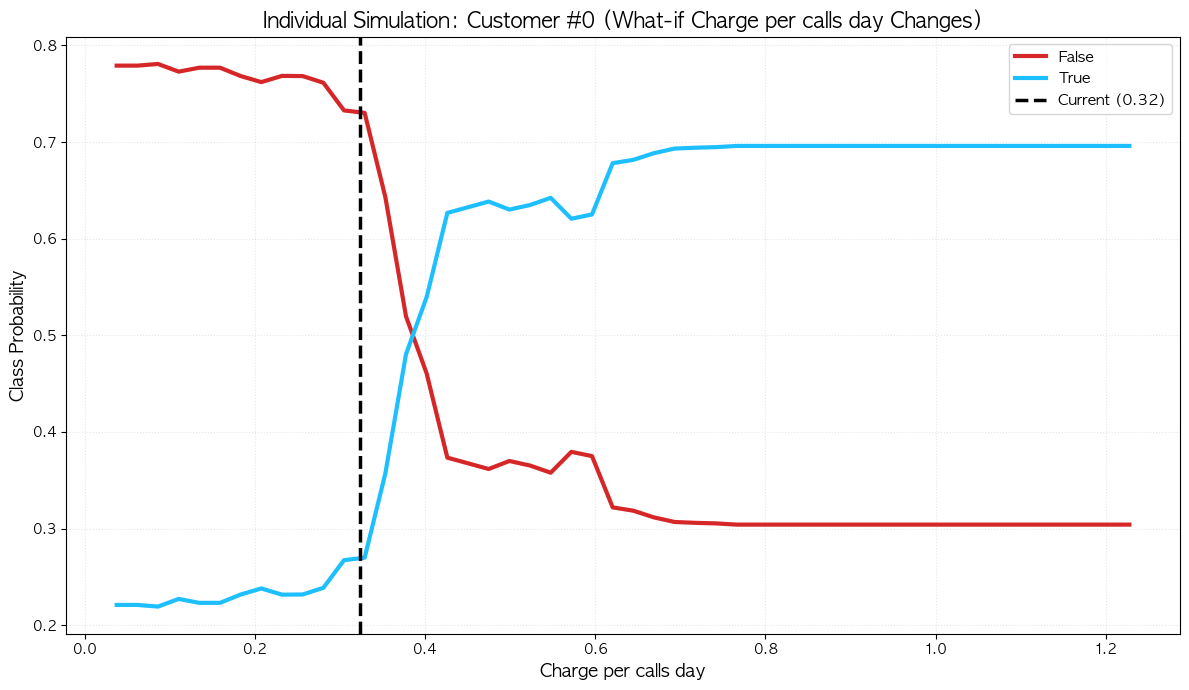


💡 [Simulation Insight]
  현재 이탈 확률: 26.6%
  최대 이탈 확률: 69.6% (at Charge per calls day = 0.77)
  이탈 가능성: +42.9%p


In [42]:

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
# 샘플 선택 (첫 번째 샘플)
sample_idx = 0
X_sample = X_test.iloc[sample_idx:sample_idx+1].copy()

for col in X_sample.columns:
    print(f"  {col}: {X_sample[col].values[0]:.2f}")

# 시뮬레이션
grid_sim = np.linspace(X_test[top_feature].min(), X_test[top_feature].max(), 50)
sim_probs = {0: [], 1: []}

for val in grid_sim:
    X_temp = X_sample.copy()
    X_temp[top_feature] = val
    probs = best_rf_model.predict_proba(X_temp)[0]
    for cls in range(2):
        sim_probs[cls].append(probs[cls])


fig, ax = plt.subplots(figsize=(12, 7))

for cls in range(2):
    ax.plot(grid_sim, sim_probs[cls], label=labels[cls], color=colors[cls], linewidth=3)

current_val = X_sample[top_feature].values[0]
ax.axvline(current_val, color='black', linestyle='--', linewidth=2.5, label=f'Current ({current_val:.2f})')

ax.set_xlabel(f'{top_feature}', fontsize=13, fontweight='bold')
ax.set_ylabel('Class Probability', fontsize=13, fontweight='bold')
ax.set_title(f'Individual Simulation: Customer #{sample_idx} (What-if {top_feature} Changes)', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

current_high_prob = best_rf_model.predict_proba(X_sample)[0, 1]
max_high_prob = max(sim_probs[1])
print(f"\n💡 [Simulation Insight]")
print(f"  현재 이탈 확률: {current_high_prob:.1%}")
print(f"  최대 이탈 확률: {max_high_prob:.1%} (at {top_feature} = {grid_sim[np.argmax(sim_probs[1])]:.2f})")
print(f"  이탈 가능성: {(max_high_prob - current_high_prob)*100:+.1f}%p")



0번째 샘플의 콜당 요금을 0.77 로 늘리면 이탈률이 약43% 증가..!

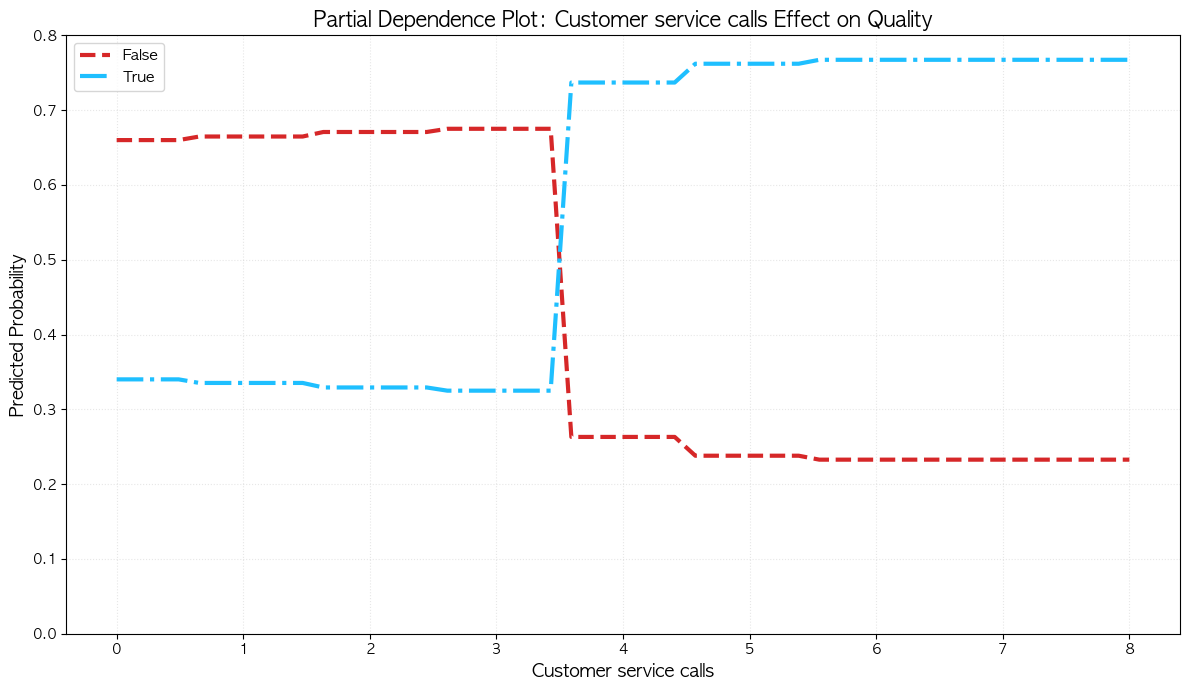

In [43]:
second_val = X_test.columns[sorted_idx[1]]

grid_values = np.linspace(X_test[second_val].min(), X_test[second_val].max(), 50)
prob_trajectories = {0: [], 1: []}

for val in grid_values:
    X_temp = X_test.copy()
    X_temp[second_val] = val

    # 평균 확률 계산
    probs = best_rf_model.predict_proba(X_temp).mean(axis=0)
    for cls in range(2):
        prob_trajectories[cls].append(probs[cls])

fig, ax = plt.subplots(figsize=(12, 7))

colors = ['#d62728',"#1ebfff"] 
labels = [False , True]
linestyles = ['--', '-.']

for cls in range(2):
    ax.plot(
        grid_values, 
        prob_trajectories[cls], 
        label=labels[cls], 
        color=colors[cls], 
        linewidth=3,
        linestyle=linestyles[cls]
    )

ax.set_xlabel(f'{second_val}', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted Probability', fontsize=13, fontweight='bold')
ax.set_title(f'Partial Dependence Plot: {second_val} Effect on Quality', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle=':')
ax.set_ylim(0, 0.8)
plt.tight_layout()
plt.show()



  International plan_dummy: 0.00
  Voice mail plan_dummy: 0.00
  Customer service calls: 1.00
  Charge per calls day: 0.32
  Charge per calls intl: 0.59


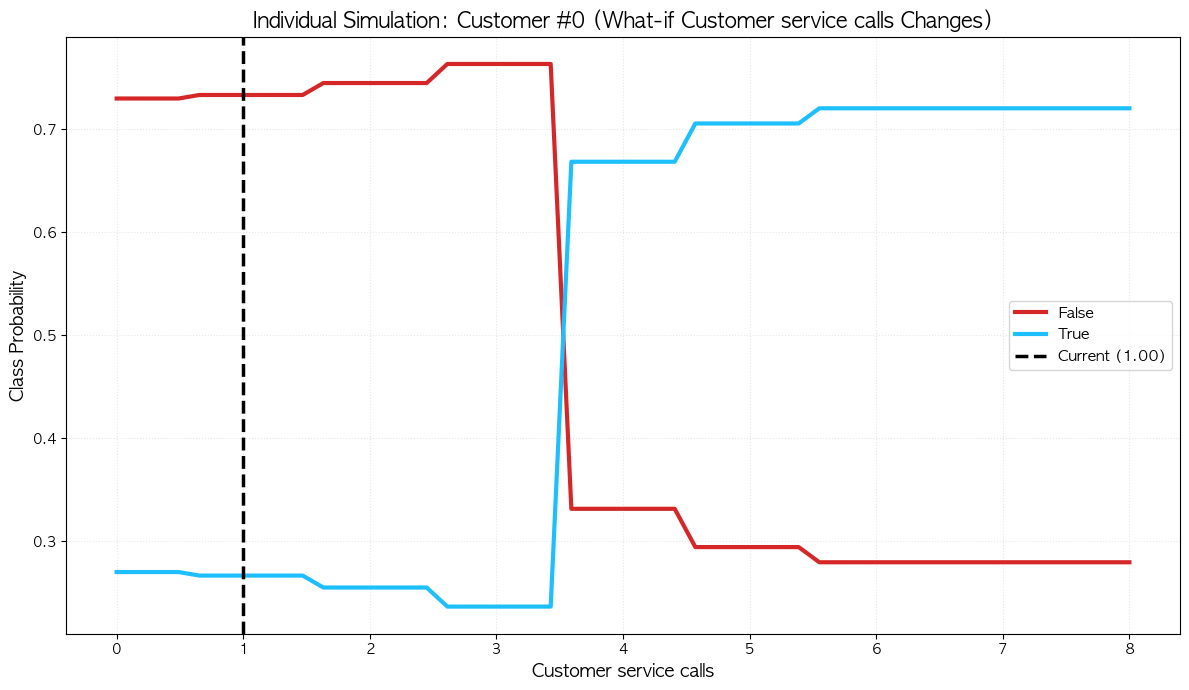


💡 [Simulation Insight]
  현재 이탈 확률: 26.6%
  최대 이탈 확률: 72.1% (at Customer service calls = 5.55)
  개선 가능성: +45.4%p


In [61]:

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
# 샘플 선택 (첫 번째 샘플)
sample_idx = 0
X_sample = X_test.iloc[sample_idx:sample_idx+1].copy()

for col in X_sample.columns:
    print(f"  {col}: {X_sample[col].values[0]:.2f}")

# 시뮬레이션
grid_sim = np.linspace(X_test[second_val].min(), X_test[second_val].max(), 50)
sim_probs = {0: [], 1: []}

for val in grid_sim:
    X_temp = X_sample.copy()
    X_temp[second_val] = val
    probs = best_rf_model.predict_proba(X_temp)[0]
    for cls in range(2):
        sim_probs[cls].append(probs[cls])


fig, ax = plt.subplots(figsize=(12, 7))

for cls in range(2):
    ax.plot(grid_sim, sim_probs[cls], label=labels[cls], color=colors[cls], linewidth=3)

current_val = X_sample[second_val].values[0]
ax.axvline(current_val, color='black', linestyle='--', linewidth=2.5, label=f'Current ({current_val:.2f})')

ax.set_xlabel(f'{second_val}', fontsize=13, fontweight='bold')
ax.set_ylabel('Class Probability', fontsize=13, fontweight='bold')
ax.set_title(f'Individual Simulation: Customer #{sample_idx} (What-if {second_val} Changes)', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

current_high_prob = best_rf_model.predict_proba(X_sample)[0, 1]
max_high_prob = max(sim_probs[1])
print(f"\n💡 [Simulation Insight]")
print(f"  현재 이탈 확률: {current_high_prob:.1%}")
print(f"  최대 이탈 확률: {max_high_prob:.1%} (at {second_val} = {grid_sim[np.argmax(sim_probs[1])]:.2f})")
print(f"  개선 가능성: {(max_high_prob - current_high_prob)*100:+.1f}%p")



0번째 고객 샘플의 고객센터 전화 횟수를 약 5회 이상으로 올리면 이탈률이 약 45% 증가..!

## PART 7. 마무리

### 🔑 주요 발견사항(Key Findings)

1. 중요 한 요인
- 고객센터 문의 횟수 : 문의가 많을수록 이탈 확률이 유의미하게 상승합니다.
- 통화당 비용 부담 : 단순 사용량보다 “비싸게 쓰는 구조”(가성비가 떨어진다)가 이탈 확률이 높습니다.

2. Feature Engineering 효과
-  Charge per calls day & Customer service calls 이 두 변수가 모델 성능 향상에 기여

3. 모델 성능
- AUC : 약 85%
- 이탈율 예측 확률(Recall) : 약 75% 
- 데이터의 불균형(전체 이탈자 약 15%)이기 때문에 약간의 정밀도(precision) 희생

### 💼 비즈니스 제언 (Actionable Recommendations)

#### 제도 및 상품 개선점

- 특정(낮)시간대의 콜 당 요금을 낮출 수 있는 정액제 등 관련 요금제 상품 개발

- 고객센터 전화 횟수가 많은(이탈고위험군) 고객우선 "전담 상담/불만 해결" 로 이탈확률 감소 기대효과 

#### 마케팅 전략

-  비용 부담형 고객들은 요금제 변경 추천 메세지를 통해 마케팅 실시